# Perturbation Theory

In this notebook, we compare the perturbation theory calculations with the ones from the vGH Ansatz.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time, os, sys, gc

import h5py 

import svgutils.transform as sg 
import sys 

import matplotlib.patches as patches

from scipy.integrate import solve_ivp

import class_energy as energy
import class_equations_of_motion as eom 

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

### Self Energy expression

We compute the self-energy obtained from the perturbative Ansatz and find the energy that fulfills the self-consistent equation.

In [2]:
def integrate_self_energy(V_0, tx, ty, B, E):
    E_self = lambda kx, ky: (2*V_0**2)/(4*np.pi**2)*(1-np.cos(kx)*np.cos(ky))/(B-E-2*tx*np.cos(kx)-2*ty*np.cos(ky))
    E_self_int = scipy.integrate.dblquad(E_self, -np.pi,np.pi, -np.pi,np.pi)
    return E_self_int

def find_Ep(V_0, tx, ty, B, E_guess):
    E_self_int = lambda E: E+integrate_self_energy(V_0, tx, ty, B, E-2*tx-2*ty)[0]
    E_min = scipy.optimize.fsolve(E_self_int, [E_guess])
    return E_min

def guess_Ep(V_0):
    return -0.004649*V_0**2-0.07471*V_0+0.8718

Here we define functions that compute the vGH and perturbative energies for different potentials.

In [26]:
def quick_pot_scan(params, V_0_arr, folder):
    h5_io_object = h_in.io_hdf5()

    print('\nvGH Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        print('V0 =', V_0_arr[i])
        params["V_0"] = V_0_arr[i]

        eom_object = eom.eom(params=params)
        wavefunc_object = h_wavef.wavefunctions(params=params)
        wfn_manip = h_wavef.wavefunc_operations(params=params)
        ''' 
        Init wavefunction
        '''
        psi_init = wavefunc_object.create_init_wavefunction(params['init_choice'])
        psi_init = wfn_manip.reshape_one_dim(psi_init)
        ''' 
        Imaginary Time Propagation
        '''
        psi, E_evo, epsilon_evo = eom_object.solve_for_fixed_params_imag_time_prop_new(psi_init)
        E_arr[i] = E_evo[-1]

        h5_io_object.save_calculation_run(psi, E_evo, epsilon_evo, params, folder)

    return E_arr

def pert_pot_scan(params, V_0_arr):
    print('\nPerturbative Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        print('V0 =', V_0_arr[i])
        E_min = find_Ep(V_0_arr[i], params["tx"], params["ty"], params["B"], guess_Ep(V_0_arr[i]))
        E_arr[i] = E_min[0]
    
    return E_arr

def get_Ep_from_E_vGH(E_vGH, tx, ty):
    return E_vGH+2*tx+2*ty

def get_E_from_Ep(E_vGH, tx, ty):
    return E_vGH-2*tx-2*ty

def get_E_arr(V_0_range, folder, check_sys, check_sym):
    h5_io_object = h_in.io_hdf5()
    
    E_arr = np.zeros(len(V_0_range), dtype=complex)
    for i in range(len(V_0_range)):
        check_sys_n = check_sys+'_V0_'+str(V_0_range[i])
        file_list = [f for f in os.listdir(folder) if check_sys_n in f and check_sym in f]
        
        if len(file_list) > 1: 
            break
        for file in file_list:
            file_name = folder+file
            psi, params = h5_io_object.get_psi(file_name)

            energy_object = energy.energy(params=params)
            E, E_T, E_B, E_V = energy_object.calc_energy(psi)
            E_arr[i] = E
    return E_arr

### Define the calculation parameters

In [28]:
params = {"n": 256,
"M": 36,
"Mx": 6,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 6,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "uniform",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [0,0,0,0],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-7}

x = (2*np.pi/params["n"])*np.arange(params["n"])

''' 
I/O Object
'''
h5_io_object = h_in.io_hdf5()

Perturbation Energies

In [5]:
V_0_range = np.linspace(0,100,21)

params["tx"] = 100
params["ty"] = 100
t = params["tx"] + params["ty"]
Ep_pert1 = pert_pot_scan(params, V_0_range)
E_pert1 = get_E_from_Ep(Ep_pert1, params["tx"], params["ty"])

params["tx"] = 50
params["ty"] = 150
Ep_pert2 = pert_pot_scan(params, V_0_range)
E_pert2 = get_E_from_Ep(Ep_pert2, params["tx"], params["ty"])

params["tx"] = 10
params["ty"] = 190
Ep_pert3 = pert_pot_scan(params, V_0_range)
E_pert3 = get_E_from_Ep(Ep_pert3, params["tx"], params["ty"])



vGH Calculations:
V0 = 0.0
V0 = 5.0
V0 = 10.0
V0 = 15.0
V0 = 20.0
V0 = 25.0
V0 = 30.0
V0 = 35.0
V0 = 40.0
V0 = 45.0
V0 = 50.0
V0 = 55.0
V0 = 60.0
V0 = 65.0
V0 = 70.0
V0 = 75.0
V0 = 80.0
V0 = 85.0
V0 = 90.0
V0 = 95.0
V0 = 100.0

vGH Calculations:
V0 = 0.0
V0 = 5.0
V0 = 10.0
V0 = 15.0
V0 = 20.0
V0 = 25.0
V0 = 30.0
V0 = 35.0
V0 = 40.0
V0 = 45.0
V0 = 50.0
V0 = 55.0
V0 = 60.0
V0 = 65.0
V0 = 70.0
V0 = 75.0
V0 = 80.0
V0 = 85.0
V0 = 90.0
V0 = 95.0
V0 = 100.0

vGH Calculations:
V0 = 0.0
V0 = 5.0
V0 = 10.0
V0 = 15.0
V0 = 20.0
V0 = 25.0
V0 = 30.0
V0 = 35.0
V0 = 40.0
V0 = 45.0
V0 = 50.0
V0 = 55.0
V0 = 60.0
V0 = 65.0
V0 = 70.0
V0 = 75.0
V0 = 80.0
V0 = 85.0
V0 = 90.0
V0 = 95.0
V0 = 100.0


vGH energies

#### Note: for big lattices, it is better to use the stand-alone python script! This cell is just suited for quick computations

In [29]:
V_0_range = np.linspace(0,100,21)

params["tx"] = 100
params["ty"] = 100
folder = 'results/perturbation_theory/tx_100_ty_100/'
E_vGH1 = quick_pot_scan(params, V_0_range, folder)

params["tx"] = 50
params["ty"] = 150
folder = 'results/perturbation_theory/tx_50_ty_150/'
E_vGH2 = quick_pot_scan(params, V_0_range, folder)

params["tx"] = 10
params["ty"] = 190
folder = 'results/perturbation_theory/tx_10_ty_190/'
E_vGH3 = quick_pot_scan(params, V_0_range, folder)



vGH Calculations:
V0 = 0.0
V0 = 5.0
V0 = 10.0
V0 = 15.0
V0 = 20.0
V0 = 25.0
V0 = 30.0
V0 = 35.0
V0 = 40.0
V0 = 45.0
V0 = 50.0
V0 = 55.0
V0 = 60.0
V0 = 65.0
V0 = 70.0
V0 = 75.0
V0 = 80.0
V0 = 85.0
V0 = 90.0
V0 = 95.0
V0 = 100.0

vGH Calculations:
V0 = 0.0
V0 = 5.0
V0 = 10.0
V0 = 15.0
V0 = 20.0
V0 = 25.0
V0 = 30.0
V0 = 35.0
V0 = 40.0
V0 = 45.0
V0 = 50.0
V0 = 55.0
V0 = 60.0
V0 = 65.0
V0 = 70.0
V0 = 75.0
V0 = 80.0
V0 = 85.0
V0 = 90.0
V0 = 95.0
V0 = 100.0

vGH Calculations:
V0 = 0.0
V0 = 5.0
V0 = 10.0
V0 = 15.0
V0 = 20.0
V0 = 25.0


KeyboardInterrupt: 

Read in the vGH calculations from the wavefunctions.

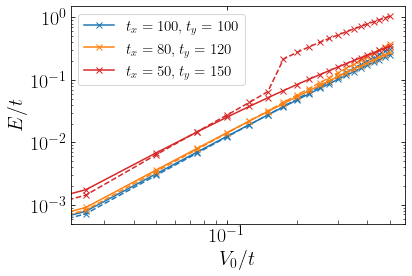

In [30]:
check_sys = 'tx_100_ty_100'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_100_ty_100/'
E_vGH1 = get_E_arr(V_0_range, folder, check_sys, check_sym)

check_sys = 'tx_50_ty_150'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_50_ty_150/'
E_vGH2 = get_E_arr(V_0_range, folder, check_sys, check_sym)

check_sys = 'tx_10_ty_190'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_10_ty_190/'
E_vGH3 = get_E_arr(V_0_range, folder, check_sys, check_sym)

## Plot the results to show how the energies match!

In [34]:
def E_to_plot(E, t):
    return -(E+2*t)/t

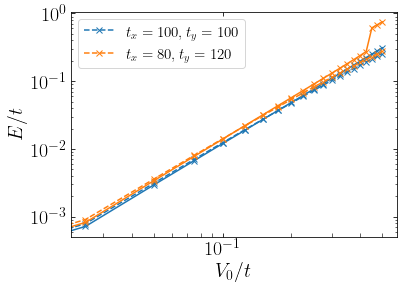

In [35]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.plot(V_0_range/t, E_to_plot(E_vGH1.real,t), marker='x', color='tab:blue', linestyle='solid')
plt.plot(V_0_range/t, E_to_plot(E_pert1.real,t), marker='x', color='tab:blue', linestyle='dashed', label=r'$t_x = 100, t_y = 100$')

plt.plot(V_0_range/t, E_to_plot(E_vGH2.real,t), marker='x', color='tab:orange', linestyle='solid')
plt.plot(V_0_range/t, E_to_plot(E_pert2.real,t), marker='x', color='tab:orange', linestyle='dashed', label=r'$t_x = 80, t_y = 120$')

#plt.plot(V_0_range/t, E_to_plot(E_vGH3.real,t), marker='x', color='tab:red', linestyle='solid')
#plt.plot(V_0_range/t, E_to_plot(E_pert3.real,t), marker='x', color='tab:red', linestyle='dashed', label=r'$t_x = 50, t_y = 150$')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$E/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)
#axs.set_yscale('log')

plt.legend(fontsize=15)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

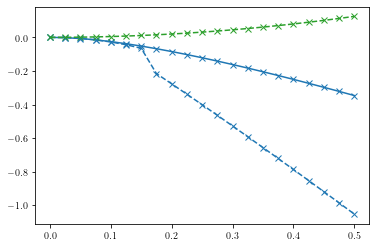

In [9]:
plt.plot(V_0_range/t, (E_pert3.real+2*t)/t, marker='x', color='tab:blue', linestyle='solid', label=r'$t_x = 100, t_y = 100$')
plt.plot(V_0_range/t, (E_vGH3.real+2*t)/t, marker='x', color='tab:blue', linestyle='dashed')
plt.plot(V_0_range/t, 0.5*(V_0_range/t)**2, marker='x', color='tab:green', linestyle='dashed')

#plt.xscale('log')
#plt.yscale('log')

In [10]:
print(E_pert3-E_vGH3)

[ 0.00000000e+00+0.j -6.34577993e-02+0.j -8.91385847e-02+0.j
  2.86725439e-02+0.j  4.04314791e-01+0.j  1.19277566e+00+0.j
  2.63951021e+00+0.j  2.96469093e+01+0.j  3.84551674e+01+0.j
  4.71987854e+01+0.j  5.58861994e+01+0.j  6.45411553e+01+0.j
  7.31596512e+01+0.j  8.17487789e+01+0.j  9.03055906e+01+0.j
  9.88392177e+01+0.j  1.07355881e+02+0.j  1.15843977e+02+0.j
  1.24323469e+02+0.j  1.32781320e+02+0.j  1.41220264e+02+0.j]


In [19]:
V_0_range = np.linspace(0,10,3)

params["tol"] = 1e-8

params["tx"] = 100
params["ty"] = 100
t = params["tx"] + params["ty"]
E_pert1, E_vGH1 = get_energies(params,V_0_range)

print(E_pert1-E_vGH1)


vGH Calculations:
V0 = 0.0
V0 = 5.0
V0 = 10.0

Perturbative Calculations:
V0 = 0.0
V0 = 5.0
V0 = 10.0
[ 0.        +0.j -0.00675135+0.j  0.00912571+0.j]
